In [69]:
# Load Packages

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns



# Standard plotly imports
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode, plot

In [63]:
## Load Data
covid = pd.read_csv('./Data/covid_19_data.csv')

mob = pd.read_csv('./Data/Global_Mobility_Report .csv')
mob = mob[mob['country_region']=='Singapore'] # restrict to Singapore

<a id='Frequencies'></a>
## **2. Confirmed Cases and Deaths Across Countries/Cities** ##

First lets look at the worldwide COVID-19 cases to see where Singapore is standing compared to other countries

In [3]:
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [4]:
covid.isnull().sum() # check for null values

SNo                    0
ObservationDate        0
Province/State     14187
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

The null values in Province/State belongs to countries that did not have data at a state/province level like Singapore, South Korea etc.

In [5]:
covid.ObservationDate = pd.to_datetime(covid.ObservationDate)
covid.ObservationDate.min(), covid.ObservationDate.max()

(Timestamp('2020-01-22 00:00:00'), Timestamp('2020-05-21 00:00:00'))

In [6]:
# Here we get the latest confirmed, deaths and recovered per country per city
latestcovid = covid.groupby(['Country/Region','Province/State'],as_index=False).agg({'Confirmed': 'max', 'Deaths': 'max', 'Recovered': 'max'})

In [7]:
latestcovid.head()

,Country/Region,Province/State,Confirmed,Deaths,Recovered
0,Australia,Australian Capital Territory,107.0,3.0,104.0
1,Australia,Diamond Princess cruise ship,0.0,0.0,0.0
2,Australia,External territories,0.0,0.0,0.0
3,Australia,From Diamond Princess,8.0,0.0,0.0
4,Australia,Jervis Bay Territory,0.0,0.0,0.0


In [8]:
# Plot treemaps

fig = px.treemap(latestcovid.sort_values(by='Confirmed', ascending=False).reset_index(drop=True), 
                 path=["Country/Region", "Province/State"], values="Confirmed", height=700, width=900,
                 title='Number of Confirmed Cases',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

fig = px.treemap(latestcovid.sort_values(by='Deaths', ascending=False).reset_index(drop=True), 
                 path=["Country/Region", "Province/State"], values="Deaths", height=700, width=900,
                 title='Number of Deaths',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

fig = px.treemap(latestcovid.sort_values(by='Recovered', ascending=False).reset_index(drop=True), 
                 path=["Country/Region", "Province/State"], values="Recovered", height=700, width=900,
                 title='Number of Recovered',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

We cannot even see Singapore in the treemaps due to its small population. Logging each country's data and using a timeseries chart will allow us to visualize and compare Singapore with the other countries better.

Check the unknowns!!

<a id='Compare_SG'></a>
### **2.1 Comparing Singapore to Other Countries** ##

In [11]:
# aggregate by country / add up all the provinces/states
byCountry = covid.groupby(['Country/Region','ObservationDate'],as_index=False).agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})

In [123]:
# Make every country start from their first case 
firstcase = byCountry[byCountry['Confirmed'] > 1]
firstdeath = byCountry[byCountry['Deaths'] > 1]
firstrecovered = byCountry[byCountry['Recovered'] > 1]

# Apply log10
firstcase.Confirmed = np.log10(firstcase.Confirmed)
firstdeath.Deaths = np.log10(firstdeath.Deaths)
firstrecovered.Recovered = np.log10(firstrecovered.Recovered)
# replace -inf with 0
firstcase.Confirmed = firstcase.Confirmed.replace(-np.inf, 0)
firstdeath.Deaths = firstdeath.Deaths.replace(-np.inf, 0)
firstrecovered.Recovered = firstrecovered.Recovered.replace(-np.inf, 0)

# Create index for each group to represent days since first case/deaths
firstcase['days_sincefirst'] = firstcase.groupby(['Country/Region'],as_index=False).cumcount()
firstdeath['days_sincefirst'] = firstdeath.groupby(['Country/Region'],as_index=False).cumcount()

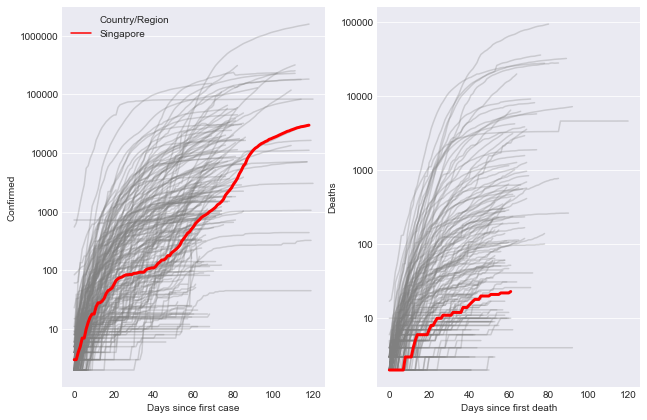

In [165]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,7))

palette = {c:'grey' for c in firstcase['Country/Region'].unique()}

plt.subplot(1,3,1)
p1=sns.lineplot(x='days_sincefirst', y='Confirmed', data=firstcase, hue='Country/Region', 
             palette=palette, alpha=.3, legend=False)
p1=sns.lineplot(x='days_sincefirst', y='Confirmed', data=firstcase[firstcase['Country/Region'] == 'Singapore'], hue='Country/Region', 
             linewidth=3, palette={'Singapore':'red'})
p1.set_yticklabels([0,10,100,1000,10000,100000,1000000])
p1.set_xlabel('Days since first case')
p1.xaxis.grid(False)

plt.subplot(1,3,2)
p2=sns.lineplot(x='days_sincefirst', y='Deaths', data=firstdeath, hue='Country/Region', 
             palette=palette, alpha=.3, legend=False)
p2=sns.lineplot(x='days_sincefirst', y='Deaths', data=firstdeath[firstdeath['Country/Region'] == 'Singapore'], hue='Country/Region', 
             linewidth=3, palette={'Singapore':'red'}, legend=False)
p2.set_yticklabels([0,10,100,1000,10000,100000])
p2.set_xlabel('Days since first death')
p2.xaxis.grid(False)

plt.show()

In [64]:
mob.columns = ['country_code', 'Country', 'region1','region2', 'date', 'retail and recreation', 'grocery and pharmacy', 'parks', 'transit stations', 'workplaces', 'residential']
mob.head()


,country_code,Country,region1,region2,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential
105316,SG,Singapore,NaN,NaN,2020-02-15,-14.0,-9.0,-10.0,-17.0,-4.0,8.0
105317,SG,Singapore,NaN,NaN,2020-02-16,-19.0,-17.0,-18.0,-22.0,-7.0,8.0
105318,SG,Singapore,NaN,NaN,2020-02-17,-12.0,-6.0,-7.0,-14.0,-4.0,7.0
105319,SG,Singapore,NaN,NaN,2020-02-18,-13.0,-9.0,-7.0,-15.0,-5.0,7.0
105320,SG,Singapore,NaN,NaN,2020-02-19,-14.0,-14.0,-6.0,-15.0,-5.0,8.0


In [65]:
# Change date column to datetime and display range
mob.date = pd.to_datetime(mob.date)
mob.date.min(), mob.date.max()

(Timestamp('2020-02-15 00:00:00'), Timestamp('2020-05-16 00:00:00'))

In [66]:
# Convert to long format
mob = mob.reset_index()
mob = pd.melt(mob, id_vars='date', value_vars=['retail and recreation', 'grocery and pharmacy', 'parks', 'transit stations', 'workplaces', 'residential'])
mob = mob.rename(columns = {'variable':'Places', 'value':'Percent_change_from_baseline'})
mob.head()

,date,Places,Percent_change_from_baseline
0,2020-02-15,retail and recreation,-14.0
1,2020-02-16,retail and recreation,-19.0
2,2020-02-17,retail and recreation,-12.0
3,2020-02-18,retail and recreation,-13.0
4,2020-02-19,retail and recreation,-14.0


In [67]:
fig = px.line(mob, x='date', y='Percent_change_from_baseline', color="Places", hover_name="Places")
fig.show()

In [ ]:
## Cluster countries into how much they got affected